# Задание 1. Bootstrap

В этом задании используйте датасет [Breast Cancer 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса 📚[wiki]](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, (`sklearn.metrics.matthews_corrcoef` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) для предсказанного ею класса и реального. Подробнее почитать про его пользу можно в статье:

[[article] 🎓 The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты 🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Установка и импорт необходимых библиотек:

In [1]:
!pip install -q dask[dataframe]

In [2]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from warnings import simplefilter

simplefilter("ignore", category=FutureWarning)

Загрузка датасета:

In [3]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [9]:
random_state = 42

In [10]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state,stratify = y)

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [18]:
from lightgbm import LGBMClassifier

dec_tree = DecisionTreeClassifier(random_state = random_state)
random_forest = RandomForestClassifier(random_state = random_state)
lightgbm = LGBMClassifier(random_state = random_state,verbose = -1)
svc = SVC(random_state = random_state)
bagging = BaggingClassifier(random_state = random_state)

In [19]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, alpha=0.05, random_state=42):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [20]:
def calculate_bootstrap_metric_for_all_models(models,x_train,y_train,x_test,y_test,metric_fn):
    bootstrap_results = []
    for mod in models:
        mod.fit(x_train,y_train)
        y_pred = mod.predict(x_test)
        boot_score_mod = bootstrap_metric(y_test,y_pred,metric_fn)
        bootstrap_results.append(boot_score_mod)
    return bootstrap_results

<ipython-input-21-9794b2416b58>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.boxplot(data=df).set_xticklabels(model_names, rotation=90)
<ipython-input-21-9794b2416b58>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=20)


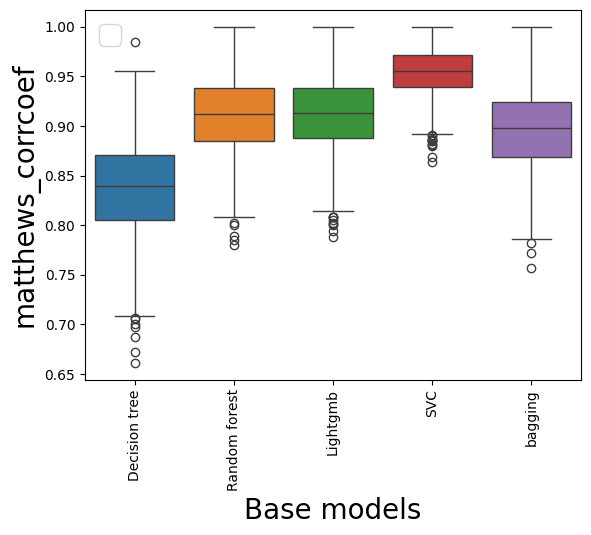

In [21]:
models = [dec_tree,random_forest,lightgbm,svc,bagging]
bootstrap_results = calculate_bootstrap_metric_for_all_models(models,x_train,y_train,x_test,y_test,metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y))

model_names = ["Decision tree","Random forest","Lightgmb","SVC","bagging"]

bootstrap_results = np.array(bootstrap_results)
bootstrap_results = np.transpose(bootstrap_results)
df = pd.DataFrame(bootstrap_results,columns = model_names)
sns.boxplot(data=df).set_xticklabels(model_names, rotation=90)
plt.xlabel("Base models", size=20)
plt.ylabel("matthews_corrcoef", size=20)
plt.legend(fontsize=20)
plt.show()

In [16]:
def print_ci_for_models(bootstrap_results,alpha,model_names):
    for mod,boot_res in zip(model_names,np.transpose(bootstrap_results)):
        print((1-alpha)*100,"% ci for",mod," - ",np.quantile(boot_res, q=[alpha / 2, 1 - alpha / 2]))

print_ci_for_models(bootstrap_results,0.1,model_names)

90.0 % ci for Decision tree  -  [0.755433   0.91136364]
90.0 % ci for Random forest  -  [0.84727026 0.96924731]
90.0 % ci for Lightgmb  -  [0.8479205 0.9688164]
90.0 % ci for SVC  -  [0.91049081 1.        ]
90.0 % ci for bagging  -  [0.82535357 0.95647255]


Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

Лучше всего по значения корреляции Мэтьюса сработал метод опорных векторов (модели не тьюнились). У него меньший разброс и значение метрик выше. RandomForestClassifier и LightGBM показали неплохие результаты (по метрикам). Худшая модель - decision tree. (Вообще, SVC лучше, если нормализовать данные, без нормализации она хуже)

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

В этом задании мы рассмотрим особенности обучения и контроля качества моделей на данных, содержащих значительный дисбаланс.

Установка и импорт необходимых библиотек:

In [22]:
!pip install -qU imbalanced-learn

In [93]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [94]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [95]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [96]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [97]:
print(f"Accuracy for model1: {accuracy_score(real_labels, model1_res):.4f}")
print(f"Accuracy for model2: {accuracy_score(real_labels, model2_res):.4f}")

Accuracy for model1: 0.7619
Accuracy for model2: 0.7619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является Balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [98]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    f"Balanced accuracy for model1: {balanced_accuracy_score(real_labels, model1_res):.3f}"
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    f"Balanced accuracy for model2: {balanced_accuracy_score(real_labels, model2_res):.3f}"
)

Balanced accuracy for model1: 0.500
Balanced accuracy for model2: 0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [99]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


,count
Response,
0,228
1,37


В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ — это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ — это использование специальных алгоритмов, учитывающих несбалансированность классов.

В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [[doc] 🛠️](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `RandomForestClassifier`, библиотека sklearn
2. [[doc] 🛠️](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `RandomForestClassifier` с балансировкой классов, библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [[doc] 🛠️](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) `BalancedRandomForestClassifier`, библиотека imblearn — семплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [32]:
from sklearn.model_selection import cross_validate
from imblearn.ensemble import BalancedRandomForestClassifier

models = [RandomForestClassifier(random_state = random_state),RandomForestClassifier(random_state = random_state,class_weight = 'balanced'),
          BalancedRandomForestClassifier(class_weight='balanced',random_state = random_state)]
model_names = ["RandomForestClassifier","RandomForestClassifier(balanced)","BalancedRandomForestClassifier"]

for name,mod in zip(model_names,models):
    cv_kfold = cross_validate(mod,x,y,cv = KFold(shuffle = True,random_state=42),scoring = ['accuracy', 'balanced_accuracy'])
    cv_strat_kfold = cross_validate(mod,x,y,cv = StratifiedKFold(shuffle = True,random_state = 42),scoring = ['accuracy', 'balanced_accuracy'])
    print(" ")
    print(name)
    print("cv_kfold results: accuracy -", np.mean(cv_kfold["test_accuracy"]),"balanced_accuracy",np.mean(cv_kfold["test_balanced_accuracy"]))
    print("cv_stratified_kfold results: accuracy -", np.mean(cv_strat_kfold["test_accuracy"]),"balanced_accuracy",np.mean(cv_strat_kfold["test_balanced_accuracy"]))
    print(" ")


 
RandomForestClassifier
cv_kfold results: accuracy - 0.8528301886792453 balanced_accuracy 0.5560479797979798
cv_stratified_kfold results: accuracy - 0.8566037735849058 balanced_accuracy 0.5304451345755694
 
 
RandomForestClassifier(balanced)
cv_kfold results: accuracy - 0.8641509433962264 balanced_accuracy 0.555182946486138
cv_stratified_kfold results: accuracy - 0.8679245283018868 balanced_accuracy 0.5491752933057281
 
 
BalancedRandomForestClassifier
cv_kfold results: accuracy - 0.7169811320754718 balanced_accuracy 0.5756678486997636
cv_stratified_kfold results: accuracy - 0.7509433962264151 balanced_accuracy 0.6276052449965493
 


Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы `cross_validate` нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции `cross_validate`).

Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

Обычный случайный лес имеет высокое значение accuracy, при этом низкое значение balanced_accuracy. Причем оно чуть ниже при использовании stratified_k_fold. Аналогично и для RandomForestClassifier(balanced). У BalancedRandomForestClassifier accuracy ниже, но balanced_accuracy выше, чем у двух других моделей. Поэтому для борьбы с дисбалансом классов лучше использовать её.

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`, оцененные на кросс-валидации с учетом стратификации по классам и без, для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier` с балансировкой классов, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn.

# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в LGBM — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* `CatBoostRegressor`
* `XGBRegressor`
* `LGBMRegressor`

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [33]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [54]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold
from warnings import simplefilter
from sklearn.metrics import mean_squared_error

simplefilter("ignore", category=FutureWarning)

Загрузка датасета:

In [35]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [45]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=random_state
)

In [47]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [62]:
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import  CatBoostRegressor

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

models_result = {}
models_mse = []
for fold, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
    print(f'Training on fold {fold}')
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    models = {'catboost':catboost.CatBoostRegressor(silent=True,random_seed=random_state),
              'xgboost': XGBRFRegressor(random_state = random_state,verbosity=0),
              'lightgbm':LGBMRegressor(random_state = random_state,verbose=-1)
              }
    for mod in models:
      models[mod].fit(x_train_fold,y_train_fold)
      y_pred = models[mod].predict(x_val_fold)
      models_result[f'{mod}_{fold}'] = models[mod]
      models_mse.append(mean_squared_error(y_val_fold,y_pred))
      print(' ')
      print(f'MSE on fold-{fold} for model {mod} = {models_mse[-1]}')
      print(' ')





Training on fold 0
 
MSE on fold-0 for model catboost = 1.5288398715065739
 
 
MSE on fold-0 for model xgboost = 1.499624227775281
 
 
MSE on fold-0 for model lightgbm = 1.5559881918076481
 
Training on fold 1
 
MSE on fold-1 for model catboost = 1.595804023830896
 
 
MSE on fold-1 for model xgboost = 1.583936217995909
 
 
MSE on fold-1 for model lightgbm = 1.637280170272136
 
Training on fold 2
 
MSE on fold-2 for model catboost = 1.5340940667927074
 
 
MSE on fold-2 for model xgboost = 1.526087458794554
 
 
MSE on fold-2 for model lightgbm = 1.5653434161218427
 


In [64]:
predictions = []
for mod in models_result:
  predictions.append(models_result[mod].predict(x_test))
  print(f'{mod} mse on test - {mean_squared_error(y_test,predictions[-1])}')

y_pred_mean = np.mean(predictions, axis=0)
mse_ensemble = mean_squared_error(y_test, y_pred_mean)
print(' ')
print("Среднее значение MSE по предсказаниям всех моделей", mse_ensemble)


catboost_0 mse on test - 1.7840504117938385
xgboost_0 mse on test - 1.7203385813461005
lightgbm_0 mse on test - 1.8716303966583248
catboost_1 mse on test - 1.6905340022113706
xgboost_1 mse on test - 1.8404822319873972
lightgbm_1 mse on test - 1.7010639916588242
catboost_2 mse on test - 2.516667561887762
xgboost_2 mse on test - 2.3097389894640417
lightgbm_2 mse on test - 2.925716966024098
 
Среднее значение MSE по предсказаниям всех моделей 1.857409610605161


## Формат результата

Получить значения MSE для всех моделей и среднее значение MSE по предсказаниям всех моделей.

**Написать вывод**

На всех фолдах лучший результат показал xgboost. Можно заметить, что среднее значение MSE по предсказаниям всех моделей получилось больше, чем MSE для некоторых моделей обученных на отдельных фолдах. В этом случае было бы не целесообразно использовать ансамблирование, лучше брать модель с наименьшим mse.


# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [65]:
!pip install -q catboost
!pip install -q optuna

In [66]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [67]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [68]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [69]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train_all,
    y_train_all,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print(f"\nmse_score before tuning: {mse(y_test, model.predict(x_test)):.4f}")

Learning rate set to 0.074308
0:	learn: 1.2817437	test: 1.2774827	best: 1.2774827 (0)	total: 3.37ms	remaining: 3.37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.242760353
bestIteration = 44

Shrink model to first 45 iterations.

mse_score before tuning: 1.5445


In [79]:
def objective(trial):
  params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'max_bin': trial.suggest_int('max_bin', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS'])
    }
  model = catboost.CatBoostRegressor(**params, silent=True,random_seed = random_state)
  model.fit(x_train_all, y_train_all)
  predictions = model.predict(x_test)
  cv_results = cross_validate(
      estimator=model,
      X=x_train,
      y=y_train,
      cv=3,
      scoring='neg_mean_squared_error',
      return_train_score=False,
      verbose=0
    )
  # print(cv_results)
  return -cv_results['test_score'].mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=50)
catboost_best_parameters = study.best_params
print(catboost_best_parameters)
print("MSE score on best estimator: ", study.best_value)

{'iterations': 607, 'learning_rate': 0.015661434738757047, 'depth': 9, 'colsample_bylevel': 0.7258063817488046, 'subsample': 0.9191128428201669, 'l2_leaf_reg': 1, 'min_data_in_leaf': 18, 'max_bin': 239, 'random_strength': 0.266511223363445, 'bootstrap_type': 'MVS'}
MSE score on best estimator:  1.516407660825135


In [80]:
model = catboost.CatBoostRegressor(**catboost_best_parameters, silent=True)
model.fit(x_train_all, y_train_all)
print(f"\nmse_score after tuning: {mse(y_test, model.predict(x_test)):.4f}")


mse_score after tuning: 1.5231


## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

# Задание 5. Ансамблевое обучение (дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям ([Heart Disease 🛠️[doc]](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci)).

Установка и импорт необходимых библиотек:

In [100]:
!pip install -q catboost
!pip install -q lightgbm

In [101]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [102]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv"
)

In [103]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
sc=StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `"hard"` или `"soft"` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [104]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel="linear", probability=True, random_state=rng)
svc_rbf = SVC(kernel="rbf", probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(
    boosting_type="rf", subsample_freq=1, subsample=0.7, random_state=42, verbose=-1
)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver="liblinear", max_iter=10000)
nb = GaussianNB()

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf,  xgb, lgbm,  xgb_rf, lgbm_rf, lr, nb]:
    scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
    print(f'{model.__class__.__name__}: {scores.mean()}')


voting_hard = VotingClassifier(estimators = [('dt',dt),('rf',rf),('etc',etc),('knn',knn),('svc_lin',svc_lin),
                                            ('svc_rbf',svc_rbf),('cat',cat),('lgbm',lgbm),('lgbm_rf',lgbm_rf),
                                            ('xgb',xgb),('xgb_rf',xgb_rf),('lr',lr),('nb',nb)],voting='hard')
voting_soft = VotingClassifier(estimators = [('dt',dt),('rf',rf),('etc',etc),('knn',knn),('svc_lin',svc_lin),
                                            ('svc_rbf',svc_rbf),('cat',cat),('lgbm',lgbm),('lgbm_rf',lgbm_rf),
                                            ('xgb',xgb),('xgb_rf',xgb_rf),('lr',lr),('nb',nb)],voting='soft')
# -----------


for model in [voting_hard, voting_soft]:
    scores = cross_val_score(
        model,
        x_train,
        y_train,
        cv=KFold(n_splits=3, shuffle=True, random_state=rng),
        scoring="f1",
    )
    print(f"{model.__class__.__name__}: {scores.mean():.4f}")

DecisionTreeClassifier: 0.7957693229810229
RandomForestClassifier: 0.7775258199977301
CatBoostClassifier: 0.8383007326745983
ExtraTreesClassifier: 0.8322016736650882
KNeighborsClassifier: 0.7972885352195697
SVC: 0.8337032822660883
SVC: 0.8217810550198527
XGBClassifier: 0.8568650829840246
LGBMClassifier: 0.8445299556410667
XGBRFClassifier: 0.821702927746441
LGBMClassifier: 0.8256752057801595
LogisticRegression: 0.814382282542939
GaussianNB: 0.8314176245210728
VotingClassifier: 0.8081
VotingClassifier: 0.8307


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [105]:
import itertools
import scipy
def base_model_pair_correlation(ensemble, x):
    corr_matrix = np.ones((len(ensemble.estimators_),len(ensemble.estimators_)))
    for (i, est1), (j, est2) in itertools.combinations(
        enumerate(ensemble.estimators_), 2
    ):
        xi_test = x_test
        xj_test = x_test
        y_pred_t1 = est1.predict_proba(xi_test)[:, 1]
        y_pred_t2 = est2.predict_proba(xj_test)[:, 1]
        corr_matrix[i][j] = scipy.stats.pearsonr(y_pred_t1, y_pred_t2)[0]
        corr_matrix[j][i] = scipy.stats.pearsonr(y_pred_t1, y_pred_t2)[0]
    return corr_matrix

<Axes: >

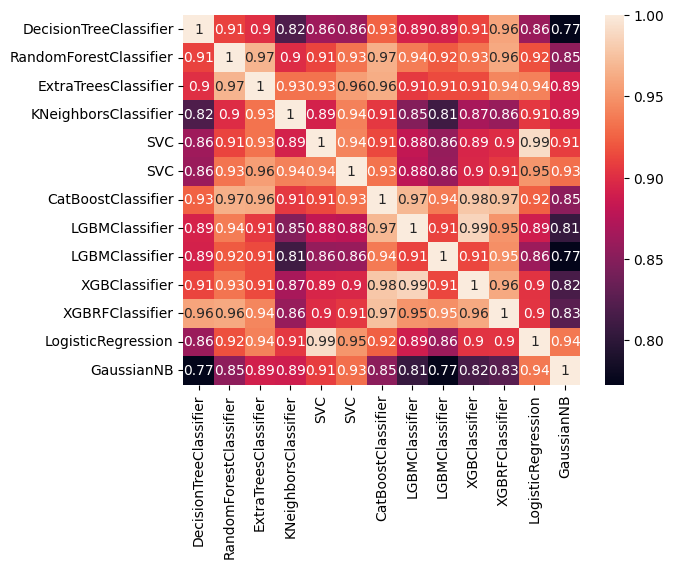

In [110]:
voting_hard.fit(x_train,y_train)
corr_matrix=base_model_pair_correlation(voting_hard,x_test)
model_names = [est.__class__.__name__ for est in voting_hard.estimators_]
sns.heatmap(corr_matrix,annot = True,xticklabels=model_names, yticklabels=model_names)

<Axes: >

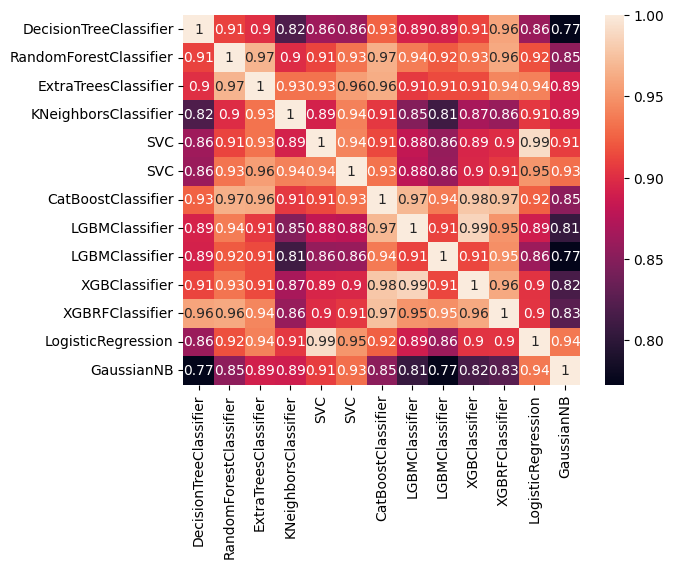

In [111]:
voting_soft.fit(x_train,y_train)
corr_matrix=base_model_pair_correlation(voting_soft,x_test)
model_names = [est.__class__.__name__ for est in voting_soft.estimators_]
sns.heatmap(corr_matrix,annot = True,xticklabels=model_names, yticklabels=model_names)

Меньше всего скоррелирована модель GaussianNB со всеми, её оставим, добавим к ней модель XGBClassifier, поскольку она даёт лучший результат. Также добавим knn и lightgbm rfclassifier. (меньше скореллированы c nb)

Создайте новый ансамбль на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.



In [134]:
# Your code here

# voting_hard_2 = VotingClassifier(estimators = [('dt',dt),('nb',nb),('knn',knn),('xgb',xgb)],voting='hard')
voting_hard_2 = VotingClassifier(estimators = [('nb',nb),('lgbm_rf',lgbm_rf),('xgb',xgb),('knn',knn)],voting='hard')
voting_soft_2 = VotingClassifier(estimators = [('nb',nb),('lgbm_rf',lgbm_rf),('xgb',xgb),('knn',knn)],voting='soft')
# ------------

for model in [voting_hard_2, voting_soft_2]:
    scores = cross_val_score(
        model,
        x_train,
        y_train,
        cv=KFold(n_splits=3, shuffle=True, random_state=rng),
        scoring="f1",
    )
    print(f"{model.__class__.__name__}: {scores.mean():.4f}")

VotingClassifier: 0.8588
VotingClassifier: 0.8569


Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [135]:
from sklearn.metrics import f1_score

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf,  xgb, lgbm,  xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft,voting_hard_2, voting_soft_2]:
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    score = f1_score(y_test,pred)
    print(f'{model.__class__.__name__} f1-score on test data: {score}')


DecisionTreeClassifier f1-score on test data: 0.8333333333333334
RandomForestClassifier f1-score on test data: 0.8571428571428571
CatBoostClassifier f1-score on test data: 0.8333333333333334
ExtraTreesClassifier f1-score on test data: 0.8809523809523809
KNeighborsClassifier f1-score on test data: 0.8888888888888888
SVC f1-score on test data: 0.8705882352941177
SVC f1-score on test data: 0.891566265060241
XGBClassifier f1-score on test data: 0.8333333333333334
LGBMClassifier f1-score on test data: 0.8192771084337349
XGBRFClassifier f1-score on test data: 0.8333333333333334
LGBMClassifier f1-score on test data: 0.8863636363636364
LogisticRegression f1-score on test data: 0.8780487804878049
GaussianNB f1-score on test data: 0.8888888888888888
VotingClassifier f1-score on test data: 0.8470588235294118
VotingClassifier f1-score on test data: 0.8470588235294118
VotingClassifier f1-score on test data: 0.8780487804878049
VotingClassifier f1-score on test data: 0.8809523809523809


Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

Лучше работают ансамбли с меньшим количеством моделей, потому что предсказания моделей сильно скореллированы. Базовые модели должны приносить что-то новое в ансамбль, иначе нет особого смысла их включать.

## Формат результата

Получить значения качества для ансамблей и моделей.